#**BERT**

- BERT uses a Transformer-based encoder only architecture, and is pre-trained on large unlabeled text corpora using masked language modeling (MLM) and next-sentence prediction (NSP)

- It produces contextualized embeddings: each word’s representation depends on its surrounding context (left and right), unlike older static embedding methods (eg word2vec / GloVe)

- BERT is mainly used for language understanding (NLU) — not text generation. It helps assistants understand what the user means, not what to reply.

- BERT sometimes underperforms for very short texts or tasks with limited data; so many works focus on combining BERT with other architectures for better performance.


- BERT / DistilBERT	used for NER, classification, embeddings	- Small, fast, cheap inference

- RoBERTa / DeBERTa	used for Classification, QA, summarization - High accuracy, Kaggle/enterprise use

- MPNet / MiniLM	used for  Vector search, semantic retrieval (RAG)	Best for FAISS/Pinecone retrieval

- T5 / Flan-T5	used for  Summarization, translation, instruction tasks	 - Lightweight text-to-text generation

- BART / Pegasus	used for  Abstractive summarization	- Less resource-hungry than LLMs

- XLNet / Electra	used for Classification, QA (legacy setups)	- Still optimized for speed

- XLM-R / mT5 / LaBSE	used for  Multilingual NLP, translation, cross-lingual search	- 100+ language support, enterprise use

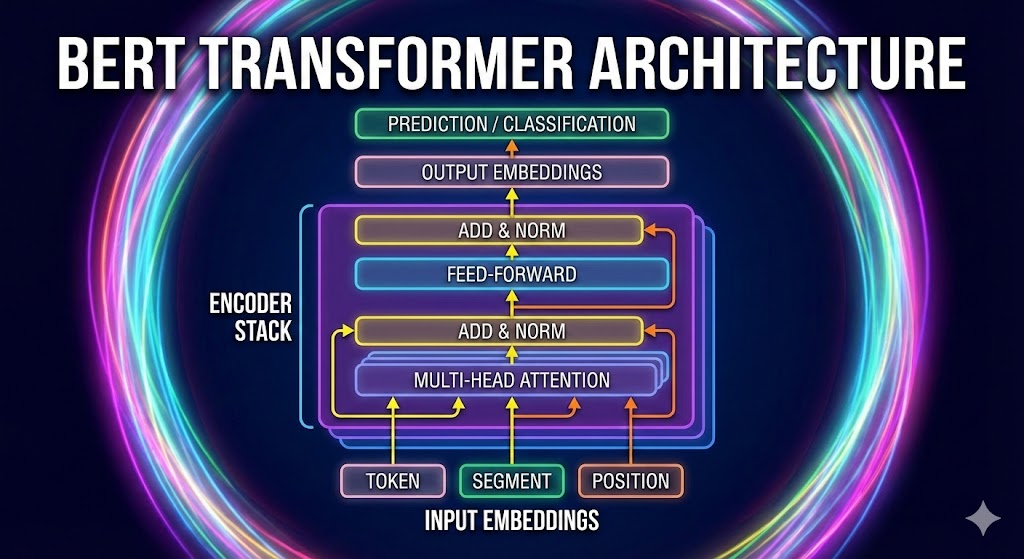

In [1]:
!pip install --upgrade datasets fsspec transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 18.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling dat

# 1. Data Collection

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, BertTokenizer, AutoModelForSequenceClassification, BertForSequenceClassification, Trainer, TrainingArguments

- AutoTokenizer automatically selects the right tokenizer based on the model checkpoint, while BertTokenizer is a fixed tokenizer class for BERT models only.

- AutoModelForSequenceClassification <br>
Automatically loads the correct model architecture for classification
You give a model name, it figures out if it’s BERT, RoBERTa, DistilBERT, etc.

- BertForSequenceClassification <br>
Specific model class only for BERT,
Adds a classification layer on top of BERT, Won’t work if you switch to  other models

In [3]:
#from datasets import load_dataset
dataset = load_dataset("ag_news")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources<br>

Classes (4 categories)<br>

Each sample belongs to exactly one of these:

- World

- Sports

- Business

- Sci/Tech

Dataset Size & Split <br>

Training: 120,000 samples (30k per class) <br>

Test: 7,600 samples (1,900 per class)<br>

Total: 127,600 samples<br>

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [5]:

train_dataset = dataset["train"].select(range(3500))
test_dataset = dataset["test"].select(range(2000))

In [6]:
len(train_dataset)

3500



---



# 2. Tokenizer

In [7]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

AutoTokenizer is a factory class that inspects the checkpoint you provide and loads the correct tokenizer automatically.

Advantages:

No need to know tokenizer type

Works for BERT, RoBERTa, ALBERT, DistilBERT, etc.

Prevents accidental tokenizer-model mismatches

In [8]:
# Tokenization function
def tokenize_fn(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)



1. This accesses the text column from the dataset.

2. padding="max_length" - Makes every sentence exactly 256 tokens long
3. truncation=True - If text is longer than 256 tokens cut the extra tokens.
4. max_length=256 - sets the fixed input size

eg - "I love pizza" <br>

{
  'input_ids': [101, 1045, 2293, 3698, 4083, 102, 0, 0, 0, ...],<br>
  'attention_mask': [1, 1, 1, 1, 1, 1, 0, 0, 0, ...]
}

input_ids - token numbers <br>

attention_mask - 1 = real token, 0 = padding <br>

Extra 0s at the end = padding <br>



---



In [9]:
train_dataset = train_dataset.map(tokenize_fn, batched=True)
test_dataset = test_dataset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

- applies your tokenizer function to every row of the dataset, converting text into model-ready numbers.

- .map(tokenize_fn, batched=True) <br>
map() applies the function to every example in the dataset. <br>
With batched=True: <br>
Processes data in chunks (batches), not one row at a time

- tokenizes the full training and test datasets, converting text into numerical inputs using batched processing for efficiency.



---



# 3. Model loading

In [10]:
# Load model
num_labels = dataset["train"].features["label"].num_classes
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

#Freezing the entire base model
for param in model.base_model.parameters () :
  param.requires_grad = False #768*4 params train

# Unfreeze only the pooler layer
for param in model.bert.pooler.parameters():
  param.requires_grad = True

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- Reads number of unique labels from dataset, Loads the correct classification model automatically Works even if you later switch from BERT to RoBERTa or DistilBERT using AutoModelForSequenceClassification

- Freezing the entire base model <br>
Freezes all BERT layers, These weights will NOT change during training Only classification head remains trainable <br> Faster training Less memory usage, Avoids overfitting on small datasets and <br>  use BERT as a feature extractor

- Unfreezing only the pooler layer <br>
Unfreezes the pooler layer only <br>
Pooler = dense layer after CLS token Allows some learning while keeping most of BERT layers frozen <br> helps in Lightweight fine-tuning Adds adaptation to your task without huge cost
- Input → [BERT Encoder (Frozen)] → [Pooler (Trainable)] → [Classifier (Trainable)] → Output
- This setup loads a pretrained BERT classifier, freezes the base model to use it as a feature extractor, and fine-tunes only the pooler and classification head for efficient training.




---



In [11]:
def count_parameters (model):
  total_params = sum(p.numel() for p in model.parameters ())
  trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return {
      "Total": total_params,
      "Trainable": trainable_params,
      "Frozen": total_params - trainable_params
  }

# Example:
param_counts = count_parameters(model)
print ('Model Parameter Counts --  ')
for k, v in param_counts.items():
  print(f'{k} : {v:,}')

Model Parameter Counts --  
Total : 109,485,316
Trainable : 593,668
Frozen : 108,891,648


- It counts how many parameters your model has in total, how many are being trained, and how many are frozen.

- total_params = sum(p.numel() for p in model.parameters()) <br>
model.parameters() gives every weight and bias in the model <br>
p.numel() - number of elements in that tensor<br>
Adds all of them up = total parameters in the model

- trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)<br>
Only counts parameters where: p.requires_grad == True<br>
These are the weights that will actually update during training.<br>

- "Frozen": total_params - trainable_params
Counts frozen parameters <br>
Usually frozen pretrained layers <br>





---



In [15]:
text = "Stock markets drop for fourth day amid relentless foreign fund outflows"

inputs = tokenizer(text, return_tensors="pt")

outputs = model(**inputs)

print(outputs)

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.1770, -0.3550, -0.1555, -0.3436]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [16]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00


In [17]:
import numpy as np
import evaluate

# Load the evaluation metric
accuracy_metric = evaluate.load("accuracy")

# Define compute metrics function
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=1)
  return accuracy_metric.compute(predictions = predictions, references = labels)

- accuracy_metric = evaluate.load("accuracy") <br>
Loads a ready-made accuracy calculator <br>
Provided by the Hugging Face Evaluate library

- logits, labels = eval_pred<br>
logits - raw model scores<br>
labels - true correct answers from dataset

- predictions = np.argmax(logits, axis=1)<br>
Takes the index of the highest score<br>
Converts raw scores into class labels

- return accuracy_metric.compute(predictions=predictions,references=labels)<br>
compares predictions vs labels and Returns something like:{'accuracy': 0.91}

- This code converts model logits(raw scores) into predicted classes and <br>computes accuracy using Hugging Face built-in evaluation API.





---



# 4. Taining Parameters


In [18]:
#from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert-finetuned-agnews",
    num_train_epochs = 3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    learning_rate=5e-5,
    weight_decay=0.01,
    report_to="none",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_strategy="steps",
    logging_steps=10,

)

# TrainingArguments controls the full training behavior including epochs, batch size, learning rate, evaluation, checkpointing, and logging..

- output_dir="./bert-finetuned-agnews" Where:trained model checkpoints logs will be saved.

- num_train_epochs=3 Model will see the entire dataset 3 times.
- per_device_train_batch_size=16 Each GPU/CPU processes 16 samples at a time during training.
- per_device_eval_batch_size=16 Batch size during evaluation/testing.
- logging_dir="./logs" Where training logs are stored.
- learning_rate=5e-5 How fast the model updates weights. Standard value for BERT fine-tuning if Too high- unstable or Too low - slow learning
- weight_decay=0.01 Adds regularization to reduce overfitting.
- report_to="none" Disables reporting to: WandB TensorBoard MLflow
- eval_strategy = "epoch" Runs evaluation After each full pass of the dataset.
- save_strategy="epoch" Saves model After each epoch.
- load_best_model_at_end = True At end of training:Reloads the checkpoint with best performance.
- metric_for_best_model = "accuracy" Defines how "best model" is chosen: Highest validation accuracy wins.
- logging_strategy="steps" - Controls when logs are written.
- logging_steps=10 log for every 10 training steps.





---



# 5. Trainer and Model Training

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-1377821198.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


- Trainer wraps model, data, and training settings into a single training pipeline that handles batching, optimization, evaluation, and checkpointing for you.

- model=model This is the pretrained + fine-tunable BERT classifier. Used for: Forward pass Loss computation Backpropagation

- args=training_args controls: learning rate, batch size, epochs, logging, evaluation strategy, checkpointing

- train_dataset=train_dataset Your tokenized training data. <br>eval_dataset=test_dataset tokenized test data.

- tokenizer=tokenizer enables padding, batch, Without this: Trainer wouldn’t know how to pad sequences.

- compute_metrics=compute_metrics This is metric computation logic. <br>
Trainer applies it after every evaluation round logs metrics like accuracy uses it to select best model


In [20]:
trainer.train() # starts training

Epoch,Training Loss,Validation Loss,Accuracy
1,0.798100,0.793525,0.768000
2,0.629200,0.611755,0.815500
3,0.535000,0.584859,0.812000


TrainOutput(global_step=657, training_loss=0.7665875730993541, metrics={'train_runtime': 266.9437, 'train_samples_per_second': 39.334, 'train_steps_per_second': 2.461, 'total_flos': 1381357845504000.0, 'train_loss': 0.7665875730993541, 'epoch': 3.0})

In [22]:
label_map = dataset["train"].features["label"].int2str # maps o → 'World', etc.

- It converts numeric class IDs into their original text labels.

- dataset["train"].features["label"]  is the label feature definition stored in the dataset schema. It contains: number of classes, mapping rules, class names
- int2str is a lookup method that: takes a number (label id)
and returns the corresponding class name

- 0 - "World" <br>
1 - "Sports"<br>
2 - "Business"<br>
3 - "Sci/Tech"<br>

- returns <br>
label_map(0) - "World"<br>
label_map(3) -  "Sci/Tech"



In [27]:
import torch

def classify (text):
  inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
  inputs={k:v.to(model.device) for k,v in inputs.items()}
  with torch.no_grad():
    outputs = model(**inputs)
    predictions = outputs.logits.argmax(dim = -1).item()
  return label_map(predictions)

- inputs = tokenizer( ) <br>
Converts plain text to token IDs & attention mask <br>
return_tensors="pt" → output is PyTorch tensors <br>truncation=True → cuts long text <br>padding=True → ensures consistent shape <br>max_length=256 → fixed input size

- inputs = {k: v.to(model.device) for k, v in inputs.items()}<br>
If model is on GPU → inputs must be on GPU<br>
If model is on CPU → inputs stay on CPU<br>
Prevents runtime crashes like<br>

- with torch.no_grad(): Disables training behavior

- outputs = model(**inputs) Feeds input into BERT and Produces raw scores (logits) per class

- predictions = outputs.logits.argmax(dim=-1).item() <br>
Picks the class with the highest score and Converts tensor to Python integer

-  return label_map(predictions) - Converts number to label name

This function tokenizes input text, runs it through the model, and converts the predicted class ID into a human-readable label.


In [28]:
print(classify('virat kohli and rohit sharma built a strong patnership and kept moving the scorecard'))

Sports
